In [119]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, LGBMRegressor

import missingno as msno

from xgboost import XGBClassifier

# Load the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/train.csv',index_col='id')
df_val = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/test.csv', index_col='id')

In [80]:
# sampling df bc its too big
sample_df = df.sample(int(len(df) * 0.2))

In [81]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

df_red = reduce_mem_usage(sample_df)

Memory usage after optimization is: 53.17 MB
Decreased by 69.7%


In [ ]:
y = df_red.claim
x = df_red.drop('claim', axis=1)

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

# Data Distribution

## Target

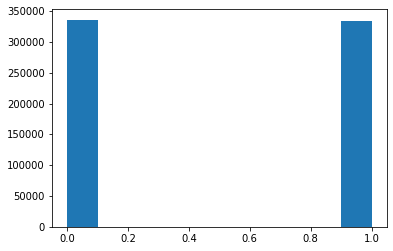

In [ ]:
plt.hist(y_train)
plt.show()

Pretty well balanced

## Features

In [ ]:
x_train.describe()

id             f1  ...           f117           f118
count  670543.000000  659861.000000  ...  659729.000000  659920.000000
mean   478933.194401       0.090221  ...    3963.129298       0.559030
std    276551.681616       0.043614  ...    3158.291221       0.408355
min         1.000000      -0.149910  ...    -415.240000      -0.151240
25%    239597.000000       0.070202  ...    1306.900000       0.276550
50%    478984.000000       0.090125  ...    3232.200000       0.473100
75%    718420.500000       0.116590  ...    6145.200000       0.745950
max    957918.000000       0.415170  ...   13151.000000       2.743600

[8 rows x 119 columns]

NameError: ignored

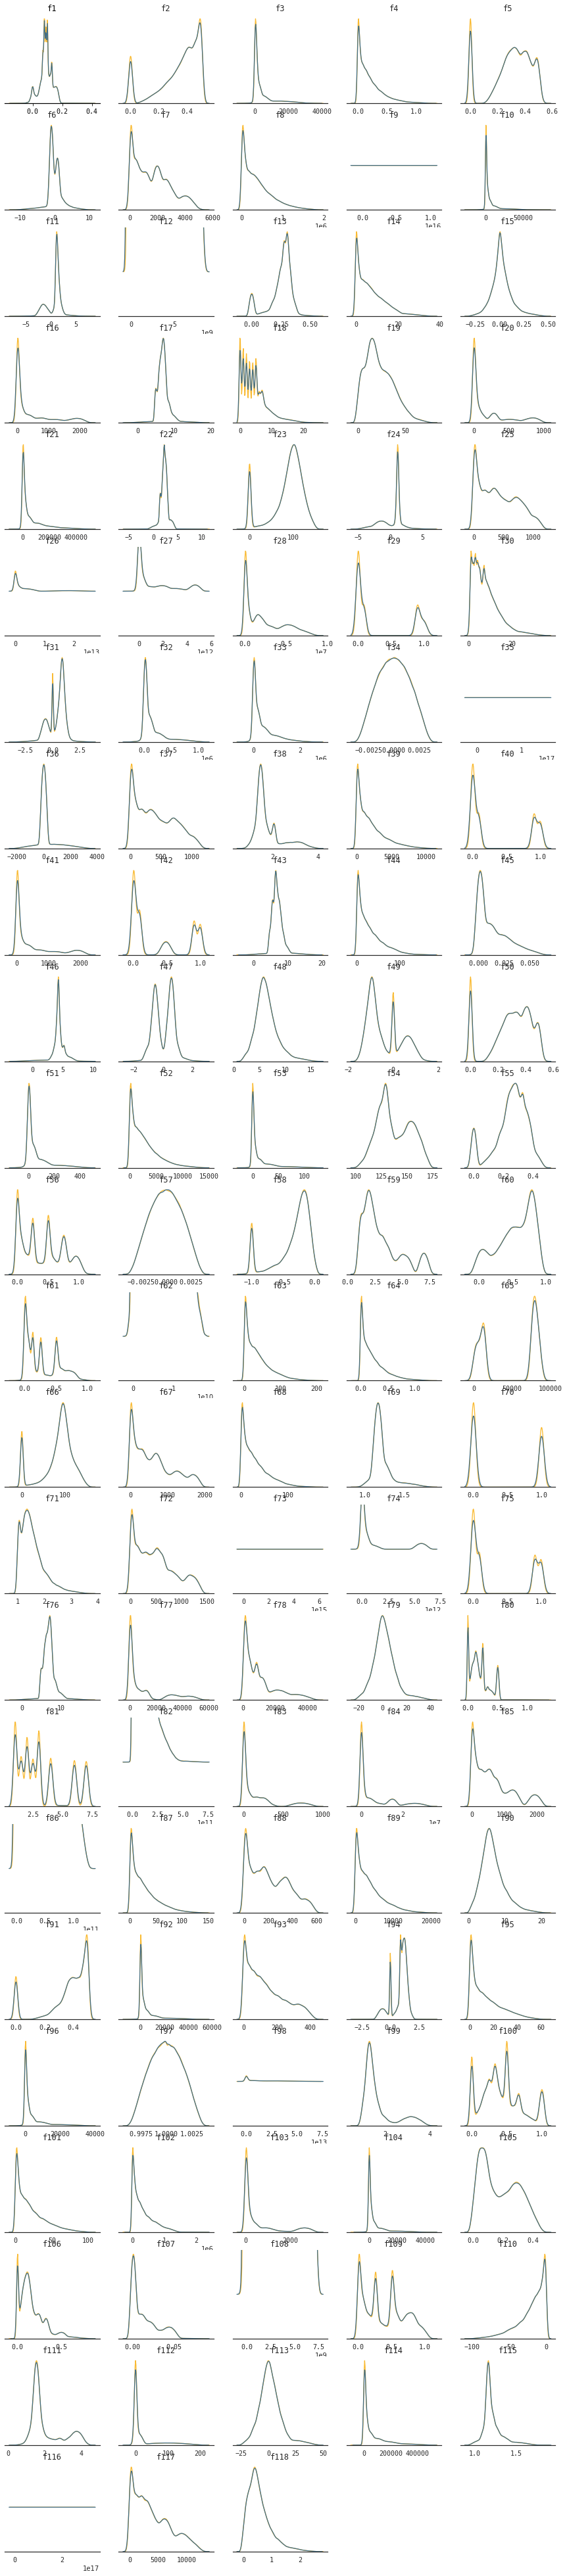

In [ ]:
train = pd.concat([x_train, y_train], axis=1,)
test = pd.concat([x_test, y_test], axis=1,)

pfig = plt.figure(figsize = (15, 71))
cols = train.columns.tolist()[1:119]
for i in cols:
    plt.subplot(24,5,cols.index(i)+1)
    sns.set_style("white")
    plt.title(i, size = 12, fontname = 'monospace')
    a = sns.kdeplot(train[i], color = '#f9ba32', linewidth = 1.3)
    sns.kdeplot(test[i], color = '#426e86', linewidth = 1.3)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname = 'monospace')
    plt.yticks([])
    for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
        a.spines['bottom'].set_linewidth(1.2)
        
fig.tight_layout(h_pad = 3)

plt.figtext(0.335, 1.02, 'Distribution of features', color = '#2f3131', fontname = 'monospace', size = 25)
plt.figtext(0.3, 1.01, 'train', color = '#f9ba32', fontname = 'monospace', size = 18)
plt.figtext(0.66, 1.01, 'test', color = '#426e86', fontname = 'monospace', size = 18)

plt.show()

# Missing Data

In [ ]:
def faltantes_percentual(df):
  """we can see how much (%) of each column is missing """
  print((df.isnull().sum() / len(df.iloc[:,0])*100).sort_values(ascending=False))

In [ ]:
faltantes_percentual(x_train)
print(faltantes_percentual(x_train).count())

In [ ]:
#plot bars with white stripes for missing values
msno.matrix(x_train)

In [ ]:
# set plot resolution and size
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(2, 15), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 2)
gs.update(wspace=1.5, hspace=0.05)

background_color = "#f6f5f5"
sns.set_palette(['#ffd514']*120)

ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0_sns = sns.barplot(ax=ax0, y=missing_train_df['feature'], x=missing_train_df['count'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1)
ax0_sns.set_xlabel("missing values",fontsize=3, weight='bold')
ax0_sns.set_ylabel("features",fontsize=3, weight='bold')
ax0_sns.tick_params(labelsize=3, width=0.5, length=1.5)
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0.text(0, -1.8, 'Train Dataset', fontsize=4, ha='left', va='top', weight='bold')
ax0.text(0, -1.105, 'Number of missing value are around 15,000 or 1.6%', fontsize=2.5, ha='left', va='top')
ax0.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# data label
for p in ax0.patches:
    value = f'{p.get_width():,.0f} | {(p.get_width()/df.shape[0]):,.1%}'
    x = p.get_x() + p.get_width() + 1000
    y = p.get_y() + p.get_height() / 2 
    ax0.text(x, y, value, ha='left', va='center', fontsize=2, 
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.2))
    
background_color = "#f6f5f5"
sns.set_palette(['#ff355d']*120)
    
ax3 = fig.add_subplot(gs[0, 1])
for s in ["right", "top"]:
    ax3.spines[s].set_visible(False)
ax3.set_facecolor(background_color)
ax3_sns = sns.barplot(ax=ax3, y=missing_test_df['feature'], x=missing_test_df['count'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1)
ax3_sns.set_xlabel("missing values",fontsize=3, weight='bold')
ax3_sns.set_ylabel("features",fontsize=3, weight='bold')
ax3_sns.tick_params(labelsize=3, width=0.5, length=1.5)
ax3_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax3_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax3.text(0, -1.8, 'Test Dataset', fontsize=4, ha='left', va='top', weight='bold')
ax3.text(0, -1.105, 'Number of missing value are around 7,000 - 8,000 or 1.6%', fontsize=2.5, ha='left', va='top')
ax3.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# data label
for p in ax3.patches:
    value = f'{p.get_width():,.0f} | {(p.get_width()/df_val.shape[0]):,.1%}'
    x = p.get_x() + p.get_width() + 500
    y = p.get_y() + p.get_height() / 2 
    ax3.text(x, y, value, ha='left', va='center', fontsize=2, 
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.2))


#t-SNE and UMAP

https://www.kaggle.com/lucamassaron/really-not-missing-at-random


In [ ]:
from cuml.manifold import TSNE, UMAP

# Model Selection

## XGBoost

In [99]:
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train_qt,y_train)
pred_xgb = xgb.predict(x_test_qt)

In [187]:
print(f'XGBoost: AUC of ROC Score: {np.round(roc_auc_score(y_test, pred_xgb)*100,3)}%') #qt

XGBoost: AUC of ROC Score: 65.205%


## LighGBM

##Baseline

In [ ]:
lgbm = LGBMClassifier(random_state=42,objective='binary')

lgbm.fit(x_train_qt,y_train, eval_set=(x_test_qt, y_test), eval_metric='roc_auc',verbose=False)
pred_lgbm = lgbm.predict(x_test_qt)

In [189]:
print(f'LGBM baseline with qt: AUC of ROC Score: {np.round(roc_auc_score(y_test, pred_lgbm)*100,3)}%') #qt

LGBM baseline with qt: AUC of ROC Score: 68.235%


# Feature Engeneer

In [173]:
class sum_missing(BaseEstimator, TransformerMixin):
  """Creates a columns with the sum of amount of missing value per row"""

  def __init__(self):
    pass
  
  def fit(self,x:pd.DataFrame ,y:pd.Series=None):
    return self

  def transform(self, df:pd.DataFrame):
    x = df.copy()
    x['sum_missing'] = x.isna().sum(axis=1)
    return x

In [183]:
#add missing indicator
pipe_fe1 = make_pipeline(SimpleImputer(missing_values = np.nan, add_indicator=True),
                        QuantileTransformer())

x_train_fe1 = pipe_fe1.fit_transform(x_train)
x_test_fe1 = pipe_fe1.fit_transform(x_test)

pred_fe1 = lgbm.fit(x_train_fe1,y_train, eval_set=(x_test_fe1, y_test), eval_metric='roc_auc',verbose=False).predict(x_test_fe1)

In [191]:
print(f'LGBM with missing indicator AUC of ROC Score: {np.round(roc_auc_score(y_test, pred_fe1)*100,3)}%')

LGBM with missing indicator AUC of ROC Score: 74.882%


In [192]:
# add a column for the sum of missing values 
pipe_fe2 = make_pipeline(sum_missing(),
                        SimpleImputer(missing_values = np.nan, add_indicator=True),
                        QuantileTransformer())

x_train_fe2 = pipe_fe2.fit_transform(x_train)
x_test_fe2 = pipe_fe2.fit_transform(x_test)

pred_fe2 = lgbm.fit(x_train_fe2,y_train, eval_set=(x_test_fe2, y_test), eval_metric='roc_auc',verbose=False).predict(x_test_fe2)
print(f'LGBM w/ miss indicator and sum of miss => AUC of ROC Score: {np.round(roc_auc_score(y_test, pred_fe2)*100,3)}%')

LGBM w/ miss indicator and sum of miss => AUC of ROC Score: 77.143%


## Cross val

In [197]:
import time

from sklearn.model_selection import StratifiedKFold

def manual_cross(X,y, N_SPLITS, cols=None):
  
  X = pd.DataFrame(X, columns=cols,)
  strat_kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

  scores = np.empty(N_SPLITS)
  for idx, (train_idx, test_idx) in enumerate(strat_kf.split(X, y)):
      print("=" * 12 + f"Training fold {idx}" + 12 * "=")
      start = time.time()

      X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
      y_train, y_val = y[train_idx], y[test_idx]
      eval_set = [(X_val, y_val)]

      lgbm_clf = lgbm.LGBMClassifier(n_estimators=10000)
      lgbm_clf.fit(
          X_train,
          y_train,
          eval_set=eval_set,
          early_stopping_rounds=200,
          eval_metric="binary_logloss",
          verbose=False,
      )

      preds = lgbm_clf.predict_proba(X_val)
      loss = log_loss(y_val, preds)
      scores[idx] = loss
      runtime = time.time() - start
      print(f"Fold {idx} finished with score: {loss:.5f} in {runtime:.2f} seconds.\n")
      

In [ ]:
manual_cross(x_train_fe2,y_train,7)

# Baseline

In [232]:
from sklearn.metrics import make_scorer

pipe_base_log = make_pipeline(SimpleImputer(),LogisticRegression())

pipe_base_log.fit(x_train, y_train)
pred_base = pipe_base_log.predict(x_test)

In [233]:
roc_auc_score(y_test, pred_base)

0.5041838944821962

# Neural Network

In [ ]:
model = Sequential()
model.add(Dense(30, input_dim=119, kernel_initializer='normal', activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(Dense(30, kernel_initializer='normal', activation='sigmoid'))
#model.add(Dropout(0.2))
#model.add(Dense(30, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(30, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [ ]:
model.fit(x_train_qt, y_train, batch_size=556, epochs = 20, validation_data=(x_test_qt, y_test))

In [ ]:
pred_nn = model.predict(x_test_qt)

In [ ]:
roc_auc_score(y_test, pred_nn)

0.5

In [ ]:
pred_nn.shape

(287376, 1)

In [ ]:
missing_train_df = pd.DataFrame(df.isna().sum())
missing_train_df = missing_train_df.drop(['id', 'claim']).reset_index()
missing_train_df.columns = ['feature', 'count']

In [ ]:
missing_train_df.head()

feature  count
0      f1  15247
1      f2  15190
2      f3  15491
3      f4  15560
4      f5  15405

# Hyperparameter tuning (OPTUNA)

In [ ]:
#code copied from https://www.kaggle.com/dmitryuarov/tps-voting-xgb-cb-lgbm

def objective(trial, data = X, target = y):

    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10000, 50000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 500),
        'gamma': trial.suggest_float('gamma', 0.0001, 1.0, log = True),
        'alpha': trial.suggest_float('alpha', 0.0001, 10.0, log = True),
        'lambda': trial.suggest_float('lambda', 0.0001, 10.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'tree_method': 'gpu_hist',
        'booster': 'gbtree',
        'random_state': 228,
        'use_label_encoder': False,
        'eval_metric': 'auc'
    }
    
    model = XGBClassifier(**params)
    scores = []
    k = StratifiedKFold(n_splits = 2, random_state = 228, shuffle = True)
    for i, (trn_idx, val_idx) in enumerate(k.split(X, y)):
        
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        model.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 300, verbose = False)
        
        tr_preds = model.predict_proba(X_train)[:,1]
        tr_score = roc_auc_score(y_train, tr_preds)
        
        val_preds = model.predict_proba(X_val)[:,1]
        val_score = roc_auc_score(y_val, val_preds)

        scores.append((tr_score, val_score))
        
        print(f"Fold {i+1} | AUC: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 300)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

# Hyperparameter tuning

In [212]:
tuned_lgbm = LGBMClassifier(learning_rate=0.01, n_estimators=900, n_jobs=-1,
                            num_leaves=51, objective='binary', random_state=42)

In [213]:
tuned_lgbm.fit(x_train_fe2,y_train)
tuned_predd = tuned_lgbm.predict(x_test_fe2)

In [214]:
print(f'AUC of ROC Score: {np.round(roc_auc_score(y_test, tuned_predd)*100,3)}%')

AUC of ROC Score: 77.188%


# Saving Progress 

In [236]:
pipe_fe3 = make_pipeline(sum_missing(),
                        SimpleImputer(missing_values = np.nan, add_indicator=True),
                        QuantileTransformer(),
                        LGBMClassifier(random_state=42,objective='binary'))

pipe_fe3.fit(x_train,y_train)

#first submission
pred_fe3 = pipe_fe3.predict(df_val)

In [ ]:
pipe_tuned1 = make_pipeline(sum_missing(),
                        SimpleImputer(missing_values = np.nan, add_indicator=True),
                        QuantileTransformer(),
                        LGBMClassifier(learning_rate=0.01, n_estimators=900, n_jobs=-1,
                            num_leaves=51, objective='binary', random_state=42))

pipe_tuned1.fit(x_train,y_train)

#second submission
tuned_sub1 = pipe_tuned1.predict(x_val)

In [259]:
data = {'id': df_val.index,
        'claim': pred_fe3}
first_sub = pd.DataFrame(data) 
first_sub.to_csv("/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/submission1.csv", index=False)

In [261]:
data2 = {'id': df_val.index,
        'claim': tuned_sub1}
second_sub = pd.DataFrame(data2) #900 estimators, learning_rate=001
second_sub.to_csv("/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/submission2.csv", index=False)